#  Loan Approval Prediction using Logistic Regression

---

###  **Goal**

Build and compare machine learning models — **Logistic Regression** — to predict whether a **loan application will be approved** or not.

This notebook covers:
-  Data preprocessing (handling missing values, encoding, scaling)
-  Baseline model training (Logistic Regression)
-  Hyperparameter tuning using **GridSearchCV**
-  Model evaluation (Accuracy, Precision, Recall, F1-Score)


---

###  **Dataset Overview**

- **Source:** [Loan Prediction Dataset – Kaggle](https://www.kaggle.com/datasets/ninzaami/loan-predication/data)  
- **Target Variable:** `Loan_Status` →  
  - `Y` = Approved  
  - `N` = Not Approved  
- **Key Predictors:**  
  `ApplicantIncome`, `CoapplicantIncome`, `LoanAmount`, `Credit_History`, `Property_Area`, etc.

---

###  **Project Workflow**

1. **Data Preprocessing**
   - Handle missing values
   - Encode categorical variables
   - Feature engineering (e.g., TotalIncome)
   - Feature scaling (for Logistic Regression)  
         
    <br>    

2. **Model Training**
    - Train baseline Logistic Regression (L1, L2, ElasticNet)

    <br>
3. **Hyperparameter Tuning**
   - Apply `GridSearchCV` for Logistic Regression Model
   - Tune key parameters (e.g., `C`, `penalty`, `max_depth`, etc.)

    <br>
                 
4. **Evaluation**
   - Assess model using Accuracy, Precision, Recall, F1-Score
   - Visualize confusion matrices and score comparison


##  Coding 
1. **Imports and basic settings**  
2. **Load dataset**  
3. **Quick EDA (Exploratory Data Analysis)**  
4. **Data preprocessing and feature engineering**
    
     4.1 Drop Loan_ID
        
     4.2 Convert loan_status to binary
                
     4.3 Create TotalIncome = ApplicantIncome + CoapplicantIncome
        
     4.4 Treat 'Dependents'
        
     4.5 Impute numeric missing (LoanAmount -> median; Loan_Amount_Term -> median)
        
     4.6 Separate features and target
        
     4.7 Column groups (numeric vs categorical)
5. **Split dataset (70/30)** 
6. **Preprocessing pipelines**
    
     6.1 Numeric transformer
        
     6.2 Categorical transformer
                
     6.3 Column Transformer
  
7. **Confusion matrix plot "defined but not called"** 
8. **Training & evaluation helper**
9. **Baseline models (train on X_train, evaluate on X_test) Logistic Regression**
10. **GridSearchCV experiments**
11. **Random forest**
12. **Summary tables & visualization**

### 1. Imports and basic settings

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

### 2. Load dataset

In [29]:
DATA_PATH = "train_data.csv"  

df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
display(df.head())

Raw shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### 3. Quick EDA

In [30]:
print("\nColumns vs missing counts:")
print(df.isnull().sum())

print("\nCounts for Loan_Status:")
print(df['Loan_Status'].value_counts(dropna=False))


Columns vs missing counts:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Counts for Loan_Status:
Loan_Status
Y    422
N    192
Name: count, dtype: int64


### 4. Data preprocessing and featuring

In [31]:
 #    4.1 Drop Loan_ID
if 'Loan_ID' in df.columns:
    df = df.drop(columns=['Loan_ID'])

In [32]:
 #    4.2 Convert loan_status to binary
if 'Loan_Status' in df.columns:
    df['Loan_Status'] = df['Loan_Status'].map({'Y':1, 'N':0})
print("Unmapped (NaN) in target:", df['Loan_Status'].isnull().sum())

Unmapped (NaN) in target: 0


In [33]:
 #    4.3 Create TotalIncome = ApplicantIncome + CoapplicantIncome
df['TotalIncome'] = df['ApplicantIncome'].fillna(0) + df['CoapplicantIncome'].fillna(0)
df['n_missing_income'] = df[['ApplicantIncome','CoapplicantIncome']].isnull().sum(axis=1)
print("\nNumber of rows with at least one missing income value:")
print((df['n_missing_income'] > 0).sum())


Number of rows with at least one missing income value:
0


In [34]:
 #    4.4 Treat 'Dependents' 

# Clean Dependents: convert '3+' to 3
df['Dependents'] = df['Dependents'].replace('3+', 3)

# Try to convert to numeric
try:
    df['Dependents'] = pd.to_numeric(df['Dependents'])
    print("Dependents successfully converted to numeric ✅")
except:
    df['Dependents'] = df['Dependents'].astype('category')
    print("Dependents kept as category ⚠️")

# Check
print("Dependents dtype:", df['Dependents'].dtype)
print("Unique Dependents values:", df['Dependents'].unique())

Dependents successfully converted to numeric ✅
Dependents dtype: float64
Unique Dependents values: [ 0.  1.  2.  3. nan]


In [35]:
 #    4.5 Impute numeric missing (LoanAmount -> median)
df['LoanAmount'] = SimpleImputer(strategy='median').fit_transform(df[['LoanAmount']])

#  log-transform LoanAmount to reduce skewness

df['LoanAmount_log'] = np.log1p(df['LoanAmount'])

In [36]:
 #    4.6 Separate features and target
TARGET = 'Loan_Status'
X = df.drop(columns=[TARGET])
y = df[TARGET]
    

In [37]:
 #    4.7 Column groups (numeric vs categorical)

numeric_features = ['LoanAmount', 'Loan_Amount_Term', 'TotalIncome', 'ApplicantIncome', 'CoapplicantIncome', 'Dependents']
# Keep ApplicantIncome & CoapplicantIncome too for model interpretability; you can drop Applicant/Coapp later
numeric_features = [f for f in numeric_features if f in X.columns]

categorical_features = [c for c in X.columns if c not in numeric_features]
# remove numeric-like from categorical
categorical_features = [c for c in categorical_features if c not in ['LoanAmount','Loan_Amount_Term','TotalIncome','ApplicantIncome','CoapplicantIncome','Dependents']]

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['LoanAmount', 'Loan_Amount_Term', 'TotalIncome', 'ApplicantIncome', 'CoapplicantIncome', 'Dependents']
Categorical features: ['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'n_missing_income', 'LoanAmount_log']


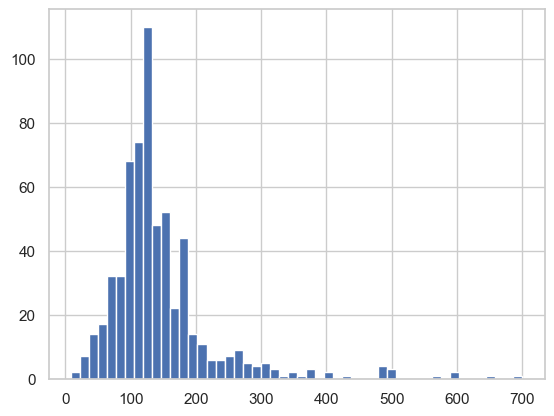

In [38]:
df['LoanAmount'].hist(bins=50)
plt.show()

### 5. Split dataset (70/30)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print("\nTrain size:", X_train.shape, " Test size:", X_test.shape)


Train size: (429, 14)  Test size: (185, 14)


### 6. Preprocessing pipelines

In [40]:
#     6.1 Numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

print("Before transformation:")
print(X[numeric_features].head())

X_num_test = numeric_transformer.fit_transform(X[numeric_features])
print("\nAfter transformation (array shape):", X_num_test.shape)


Before transformation:
   LoanAmount  Loan_Amount_Term  TotalIncome  ApplicantIncome  \
0       128.0             360.0       5849.0             5849   
1       128.0             360.0       6091.0             4583   
2        66.0             360.0       3000.0             3000   
3       120.0             360.0       4941.0             2583   
4       141.0             360.0       6000.0             6000   

   CoapplicantIncome  Dependents  
0                0.0         0.0  
1             1508.0         1.0  
2                0.0         0.0  
3             2358.0         0.0  
4                0.0         0.0  

After transformation (array shape): (614, 6)


In [41]:
#     6.2 Categorical transformer

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


In [42]:
#     6.3 Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


### 7. Confusion matrix plot "defined but not called"

In [43]:
def plot_conf_mat(y_true, y_pred, title="Confusion matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0','Pred 1'], yticklabels=['Actual 0','Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

### 8. Training & evaluation helper 


=== Logistic Regression ===
Train: {'accuracy': 0.8927738927738927, 'precision': 0.8927444794952681, 'recall': 0.9593220338983051, 'f1': 0.9248366013071896}
Test : {'accuracy': 0.7405405405405405, 'precision': 0.8062015503875969, 'recall': 0.8188976377952756, 'f1': 0.8125}


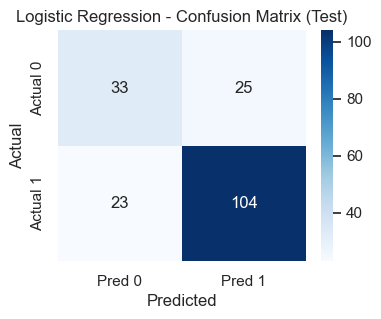

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'TotalIncome',
                                                   'ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'Dependents']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Married',
                                                   'Education', 'Self_Employed',
                                                   'Credit_History',
                                                   'Property_Area',
                                                   'n_missing_income',
                                                   'LoanAmount_log'])])),
                ('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=1000))])

In [46]:
# (uses preprocessor and scaling for LR)
results = []

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    needs_scaling = isinstance(model, LogisticRegression)
    steps = [('preprocessor', preprocessor)]
    if needs_scaling:
        steps.append(('scaler', StandardScaler()))
    steps.append(('clf', model))
    pipe = Pipeline(steps=steps)
    pipe.fit(X_train, y_train)               # fit only on training data
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)
    train_scores = {
        'accuracy': accuracy_score(y_train, y_pred_train),
        'precision': precision_score(y_train, y_pred_train, zero_division=0),
        'recall': recall_score(y_train, y_pred_train, zero_division=0),
        'f1': f1_score(y_train, y_pred_train, zero_division=0)
    }
    test_scores = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test, zero_division=0),
        'recall': recall_score(y_test, y_pred_test, zero_division=0),
        'f1': f1_score(y_test, y_pred_test, zero_division=0)
    }
    results.append({
        'model': name,
        'estimator': pipe,
        'train_scores': train_scores,
        'test_scores': test_scores
    })
    print(f"\n=== {name} ===")
    print("Train:", train_scores)
    print("Test :", test_scores)

    
    plot_conf_mat(y_test, y_pred_test, title=f"{name} - Confusion Matrix (Test)")
    return pipe

evaluate_model("Logistic Regression", LogisticRegression(max_iter=1000), X_train, X_test, y_train, y_test)

### 9. Baseline models (train on X_train, evaluate on X_test) Logistic Regression


=== Logistic_L2 ===
Train: {'accuracy': 0.8927738927738927, 'precision': 0.8927444794952681, 'recall': 0.9593220338983051, 'f1': 0.9248366013071896}
Test : {'accuracy': 0.7405405405405405, 'precision': 0.8062015503875969, 'recall': 0.8188976377952756, 'f1': 0.8125}


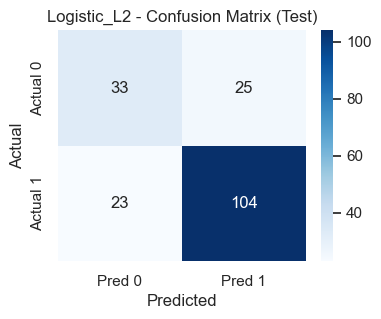


=== Logistic_L1 ===
Train: {'accuracy': 0.8904428904428905, 'precision': 0.8780487804878049, 'recall': 0.976271186440678, 'f1': 0.9245585874799358}
Test : {'accuracy': 0.7621621621621621, 'precision': 0.8217054263565892, 'recall': 0.8346456692913385, 'f1': 0.828125}


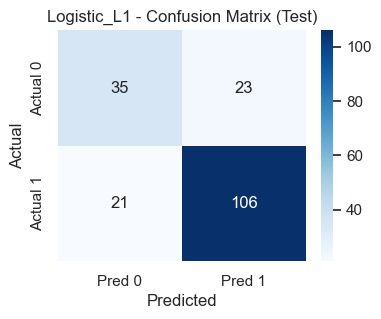


=== Logistic_ElasticNet_l1ratio0.5 ===
Train: {'accuracy': 0.8974358974358975, 'precision': 0.8885448916408669, 'recall': 0.9728813559322034, 'f1': 0.9288025889967637}
Test : {'accuracy': 0.7567567567567568, 'precision': 0.8153846153846154, 'recall': 0.8346456692913385, 'f1': 0.8249027237354085}


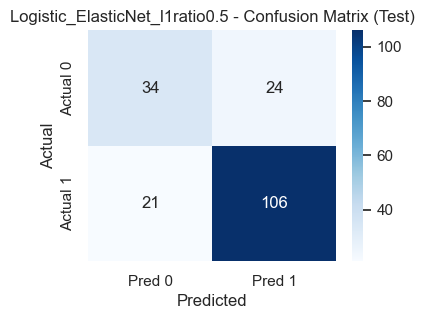

In [47]:
lr_l2 = LogisticRegression(penalty='l2', solver='saga', max_iter=5000, random_state=42)
pipe_lr_l2 = evaluate_model("Logistic_L2", lr_l2, X_train, X_test, y_train, y_test)

lr_l1 = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42)
pipe_lr_l1 = evaluate_model("Logistic_L1", lr_l1, X_train, X_test, y_train, y_test)

lr_en = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=5000, random_state=42)
pipe_lr_en = evaluate_model("Logistic_ElasticNet_l1ratio0.5", lr_en, X_train, X_test, y_train, y_test)

### 10. GridSearchCV experiments

Fitting 5 folds for each of 60 candidates, totalling 300 fits

*** GridSearch LogisticRegression Best Params: {'clf__C': 0.01, 'clf__l1_ratio': 0.25, 'clf__penalty': 'elasticnet'}
Train: {'accuracy': 0.7925407925407926, 'precision': 0.7754010695187166, 'recall': 0.9830508474576272, 'f1': 0.866965620328849}
Test : {'accuracy': 0.8486486486486486, 'precision': 0.8278145695364238, 'recall': 0.984251968503937, 'f1': 0.8992805755395683}


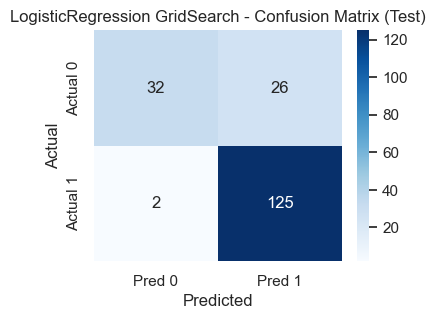

In [48]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Helper to run GridSearch and save best model & metrics
def run_grid_search(name, base_model, param_grid, scoring='f1'):
    # create pipeline that includes scaling if it's LR
    needs_scaling = isinstance(base_model, LogisticRegression)
    steps = [('preprocessor', preprocessor)]
    if needs_scaling:
        steps.append(('scaler', StandardScaler()))
    steps.append(('clf', base_model))
    pipe = Pipeline(steps=steps)

    gs = GridSearchCV(pipe, param_grid=param_grid, cv=skf, scoring=scoring, n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    # Predictions
    y_pred_train = best.predict(X_train)
    y_pred_test = best.predict(X_test)
    train_scores = {
        'accuracy': accuracy_score(y_train, y_pred_train),
        'precision': precision_score(y_train, y_pred_train, zero_division=0),
        'recall': recall_score(y_train, y_pred_train, zero_division=0),
        'f1': f1_score(y_train, y_pred_train, zero_division=0)
    }
    test_scores = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test, zero_division=0),
        'recall': recall_score(y_test, y_pred_test, zero_division=0),
        'f1': f1_score(y_test, y_pred_test, zero_division=0)
    }
    results.append({
        'model': name + "_GridSearch",
        'estimator': best,
        'train_scores': train_scores,
        'test_scores': test_scores,
        'pipeline': best,
        'grid_search': gs
    })
    print(f"\n*** GridSearch {name} Best Params: {gs.best_params_}")
    print("Train:", train_scores)
    print("Test :", test_scores)
    plot_conf_mat(y_test, y_pred_test, title=f"{name} GridSearch - Confusion Matrix (Test)")
    return gs

# Logistic Regression GridSearch
lr_base = LogisticRegression(max_iter=5000, solver='saga', random_state=42)
param_grid_lr = {
    'clf__penalty': ['l1','l2','elasticnet'],
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]  # l1_ratio used only if penalty=elasticnet; GridSearch handles unused params
}
gs_lr = run_grid_search("LogisticRegression", lr_base, param_grid_lr, scoring='f1')


### 11. Random forest 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

*** GridSearch RandomForest Best Params: {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 100}
Train: {'accuracy': 0.8088578088578089, 'precision': 0.7901907356948229, 'recall': 0.9830508474576272, 'f1': 0.8761329305135952}
Test : {'accuracy': 0.8324324324324325, 'precision': 0.8243243243243243, 'recall': 0.9606299212598425, 'f1': 0.8872727272727273}


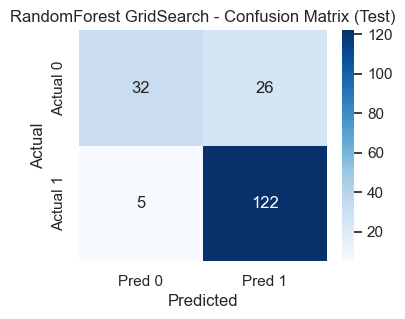

In [49]:
# Random Forest GridSearch (as requested)
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid_rf = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_leaf': [1, 2, 4]
}
gs_rf = run_grid_search("RandomForest", rf_base, param_grid_rf, scoring='f1')

### 12. Summary tables & visualization


--- Experiment summary (sorted by test F1) ---


,model,train_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_precision,test_recall,test_f1
0,LogisticRegression_GridSearch,0.7925,0.7754,0.9831,0.8670,0.8486,0.8278,0.9843,0.8993
1,RandomForest_GridSearch,0.8089,0.7902,0.9831,0.8761,0.8324,0.8243,0.9606,0.8873
2,Logistic_L1,0.8904,0.8780,0.9763,0.9246,0.7622,0.8217,0.8346,0.8281
3,Logistic_ElasticNet_l1ratio0.5,0.8974,0.8885,0.9729,0.9288,0.7568,0.8154,0.8346,0.8249
4,Logistic_L2,0.8928,0.8927,0.9593,0.9248,0.7405,0.8062,0.8189,0.8125
5,Logistic Regression,0.8928,0.8927,0.9593,0.9248,0.7405,0.8062,0.8189,0.8125



Total experiments run: 6
Model families tried: 4

Saved summary to model_experiment_summary.csv


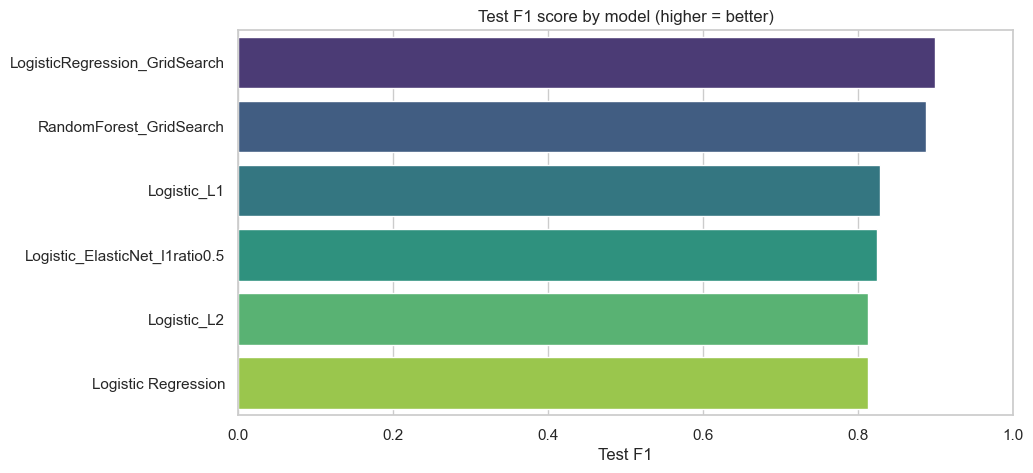

In [50]:
summary_rows = []
for r in results:
    summary_rows.append({
        'model': r['model'],
        'train_accuracy': round(r['train_scores']['accuracy'], 4),
        'train_precision': round(r['train_scores']['precision'], 4),
        'train_recall': round(r['train_scores']['recall'], 4),
        'train_f1': round(r['train_scores']['f1'], 4),
        'test_accuracy': round(r['test_scores']['accuracy'], 4),
        'test_precision': round(r['test_scores']['precision'], 4),
        'test_recall': round(r['test_scores']['recall'], 4),
        'test_f1': round(r['test_scores']['f1'], 4),
    })
summary_df = pd.DataFrame(summary_rows).sort_values(by='test_f1', ascending=False).reset_index(drop=True)
print("\n--- Experiment summary (sorted by test F1) ---")
display(summary_df)

print("\nTotal experiments run:", len(results))
print("Model families tried:", summary_df['model'].apply(lambda x: x.split('_')[0]).nunique())


summary_df.to_csv("model_experiment_summary.csv", index=False)
print("\nSaved summary to model_experiment_summary.csv")


plt.figure(figsize=(10,5))
sns.barplot(x='test_f1', y='model', data=summary_df, palette='viridis')
plt.title('Test F1 score by model (higher = better)')
plt.xlabel('Test F1')
plt.ylabel('')
plt.xlim(0,1)
plt.show()
